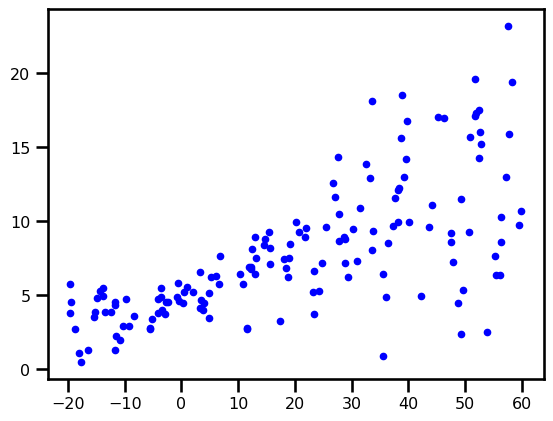

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tf_keras.src.layers.core.dense.Dense object at 0x1655c5f30> (of type <class 'tf_keras.src.layers.core.dense.Dense'>)

In [3]:


# Linear regression using MLE with fixed variance and input-dependent variance.
# Adapted from
# https://colab.sandbox.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb#scrollTo=5zCEYpzu7bDX


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

try:
    import tensorflow.compat.v2 as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

try:
    import tensorflow_probability as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import os

figdir = "figures"


def savefig(fname):
    plt.savefig(os.path.join(figdir, fname))


sns.reset_defaults()
# sns.set_style('whitegrid')
# sns.set_context('talk')
sns.set_context(context="talk", font_scale=0.7)

tfd = tfp.distributions


# @title Synthesize dataset.
w0 = 0.125
b0 = 5.0
x_range = [-20, 60]


def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.0)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1.0 + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst


y, x, x_tst = load_dataset()


plt.figure()
# plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, "b.", label="observed")
savefig("linreg_1d_hetero_data.pdf")
plt.show()

version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
    import tf_keras as keras
else:
    keras = tf.keras

### Fixed output variance
model = tf.keras.Sequential(
    [
        keras.layers.Dense(1),  # 1 linear layer
        tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
    ]
)

negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
history = model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

plt.plot(history.history["loss"], label="Train")
# plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.show()


plt.figure()
plt.plot(x, y, "b.", label="observed")
plt.plot(x_tst, yhat.mean(), "r", label="mean", linewidth=4)
savefig("linreg_1d_hetero_mean.pdf")
plt.show()


plt.figure()
plt.plot(x, y, "b.", label="observed")
m = yhat.mean()
s = yhat.stddev()
plt.plot(x_tst, m, "r", linewidth=4, label="mean")
plt.plot(x_tst, m + 2 * s, "g", linewidth=2, label=r"mean + 2 stddev")
plt.plot(x_tst, m - 2 * s, "g", linewidth=2, label=r"mean - 2 stddev")
savefig("linreg_1d_hetero_var_fixed.pdf")
plt.show()

# Data-dependent variance (heteroskedastic)

# mu(x) = b + wx
# sigma(x) = softplus( 0.05 * b' + w' x)
model = tf.keras.Sequential(
    [
        keras.layers.Dense(1 + 1),  # linear model for mean and variance
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))
        ),
    ]
)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


plt.figure()
plt.plot(x, y, "b.", label="observed")
m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, "r", linewidth=4, label="mean")
plt.plot(x_tst, m + 2 * s, "g", linewidth=2, label=r"mean + 2 stddev")
plt.plot(x_tst, m - 2 * s, "g", linewidth=2, label=r"mean - 2 stddev")
savefig("linreg_1d_hetero_var_adaptive.pdf")
plt.show()
     

In [7]:
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
    import tf_keras as keras
else:
    keras = tf.keras

3.3.3
importing old
